In [73]:
from datagenerator import DataGen
import numpy as np
import tensorflow as tf
import scipy as sc
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
%matplotlib inline

from IPython import display

tf.enable_eager_execution()

In [75]:
def single_chi_sq_dist(x, y):
    return 0.5 * np.sum((x-y)**2 / (x+y))

def chi_sq_dist(X):
    X_1 = tf.expand_dims(X, 1)
    X_2 = tf.expand_dims(X, 0)

    epsilon = tf.constant(0.000001)
    
    return 0.5 * tf.reduce_sum(tf.squared_difference(X_1, X_2) / (X_1+X_2 + epsilon), 2)

def chi_sq_nn(X):
    dist = chi_sq_dist(X)
    return np.argsort(np.abs(dist),axis=1)

def euclidean_nn(X):
    dist = distance_matrix(X,X)
    return np.argsort(dist,axis=1)

In [172]:
#X, y = DataGen.gauss(100, 3)
#X, y = DataGen.moons(100,10)
#X, y = DataGen.gauss(100, 2)
X, y = load_breast_cancer(return_X_y=True)
X, y = X[:100], y[:100]
#X = np.hstack((X,np.zeros((X.shape[0],1))))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#X, y = X_train, y_train

N = X.shape[0]
dims = X.shape[1]
K = 5


In [173]:
knc = KNeighborsClassifier(n_neighbors=K, algorithm='ball_tree', metric='pyfunc', 
                           metric_params={'func': single_chi_sq_dist})
knc.fit(X_train, y_train)
y_hat = knc.predict(X_test)
acc = np.sum(y_hat == y_test) / len(y_test)
acc

0.8787878787878788

In [174]:
nearest_points = chi_sq_nn(X.astype('float32'))
#nearest_points = euclidean_nn(X.astype('float32'))


In [175]:
## Same Class Neighbors - Automatic v2.0
nn = np.zeros((N*K,2), dtype=np.int32)
for i in range(N):
    tmp = nearest_points[i]
    idx = [elem for elem in tmp if elem in np.where(y==y[i])[0]]
    nn[i::N,1] = idx[1:K+1]
    nn[i::N,0] = np.repeat(idx[0], K)

0


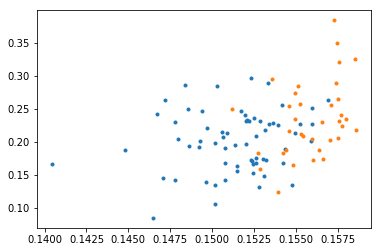

In [176]:
def plot_func(X,y):
    classes = np.unique(y)
    #plt.axis('equal')
    tmp = X.copy()
    tmp[:, 0] = X[:, 0] / X[:, 2]
    tmp[:, 1] = X[:, 1] / X[:, 2]
    
    for i in classes:
        plt.plot(tmp[y==i,0], tmp[y==i,1],'.')
    #plt.show()

t = 5
print(y[t])
plot_func(X,y)
#plt.plot(X[int(nn[t,0]),0],X[int(nn[t,0]),1],'x')
#plt.plot(X[nn[t,1:].astype(np.int),0],X[nn[t,1:].astype(np.int),1],'*')
#plt.plot(X[im[t,:].astype(np.int),0],X[im[t,:].astype(np.int),1],'*')
plt.show()


In [177]:
def get_impostors(D, nn, y, margin):
    idxs = tf.reshape(tf.tile(tf.range(N),[N*K]), (N*N*K,1))
    tn_idxs = tf.reshape(tf.tile(nn, [1, N]), (-1, 2))
    all_idxs = tf.concat([tn_idxs, idxs], axis=1)

    tn_index = all_idxs[:,:2]
    im_index = all_idxs[:,::2]
    tn_distance = tf.gather_nd(D, tn_index)
    im_distance = tf.gather_nd(D, im_index)
    
    is_too_close = im_distance <= margin + tn_distance
    is_different_class = tf.not_equal(tf.gather(y, tn_index[:,1]), tf.gather(y, im_index[:,1]))

    predicate = tf.logical_and(is_too_close, is_different_class)
    return tf.boolean_mask(all_idxs, predicate) # (idx, target neighbour index, imposter index)

def loss(X, A, nn, y, margin):
    L = tf.nn.softmax(A,axis=0)
    #X_bar = tf.cast(X @ L, tf.float32)
    X_bar = tf.transpose(tf.cast(L @ X.T, tf.float32))
    D = chi_sq_dist(X_bar)
    
    im_triple = get_impostors(D, nn, y, margin)
    
    pull_term = tf.gather_nd(D, nn) # (N*K, 1) where each element 
    pull_loss = tf.reduce_sum(pull_term)

    push_loss = tf.reduce_sum(margin + tf.gather_nd(D, im_triple[:,:2]) - tf.gather_nd(D, im_triple[:,::2]))  
    loss = pull_loss + mu * push_loss
    return loss

def grad(X, A, nn, y, margin):
    with tf.GradientTape() as tape:
        loss_value = loss(X, A, nn, y, margin)
    return tape.gradient(loss_value, A)

In [178]:
tmp = np.tile(np.sum(X, axis=1), (dims, 1)).T
X = X / tmp

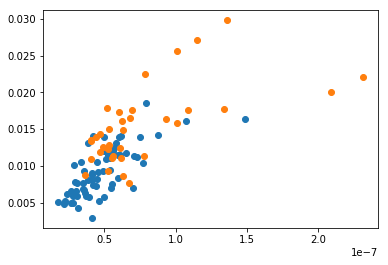

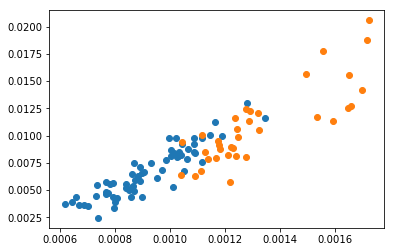

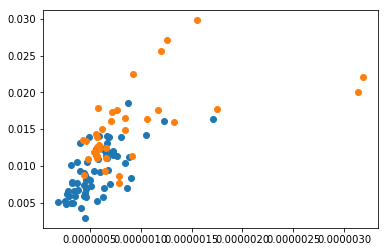

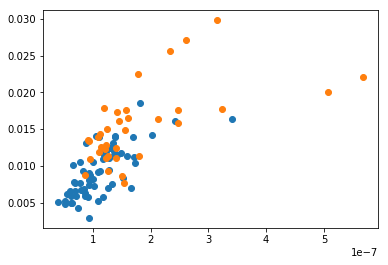

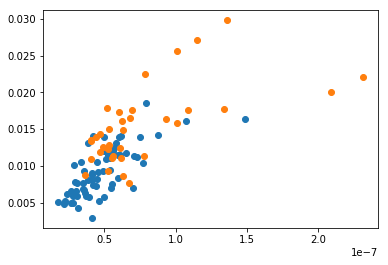

In [185]:
r = dims
A = tf.Variable(np.eye(r, dims) + 0.01* np.ones((r,dims)))

margin = 0.5
mu = 10000

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
#plot_func(X @ np.array(tf.nn.softmax(A,axis=0)), y)
for i in range(200):
    grads = grad(X, A, nn, y, margin)
    optimizer.apply_gradients(zip([grads], [A]))
    
    if i % 50 == 0:
        print(loss(X, A, nn, y, margin).numpy())
        plt.figure()
        L = np.array(tf.nn.softmax(A,axis=0))
        x_bar = (L @ X.T).T
        for i in range(3):
            plt.plot(x_bar[y==i,0], x_bar[y==i,1] , 'o')
        #plot_func(X @ np.array(tf.nn.softmax(A,axis=0)),y)
        #plt.title(loss(X, A, nn, y, margin).numpy())
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        

#optimizer.minimize(loss)

In [186]:
L = np.array(tf.nn.softmax(A,axis=0))
knc = KNeighborsClassifier(n_neighbors=K, algorithm='ball_tree', metric='pyfunc', 
                           metric_params={'func': single_chi_sq_dist})
knc.fit((L @ X_train.T).T, y_train)
y_hat = knc.predict((L @ X_test.T).T)
acc = np.sum(y_hat == y_test) / len(y_test)
acc


0.8787878787878788

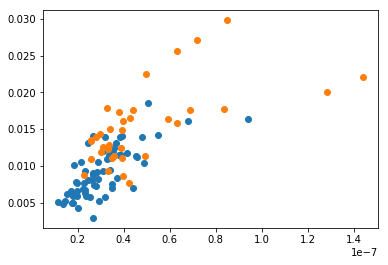

In [187]:
x_bar = (L @ X.T).T
for i in range(3):
    plt.plot(x_bar[y==i,0], x_bar[y==i,1] , 'o')

In [183]:
L

array([[9.22787070e-09, 1.56387164e-07, 1.19888900e-21, 0.00000000e+00,
        8.39285976e-05, 4.05290107e-04, 9.99091362e-01, 9.99263150e-01,
        1.55409083e-07, 1.78487951e-04, 1.39795815e-05, 3.21335818e-28,
        2.93057723e-17, 9.99998730e-01, 1.30319788e-03, 6.73786111e-04,
        3.68148338e-04, 1.56043430e-03, 4.79545157e-04, 2.74100819e-03,
        2.15561309e-06, 5.60642367e-11, 6.59811134e-20, 1.00000000e+00,
        1.36381085e-05, 9.97000547e-01, 9.97781324e-01, 9.99200876e-01,
        4.21120288e-10, 1.68117273e-04],
       [9.99999991e-01, 9.99999844e-01, 1.00000000e+00, 1.00000000e+00,
        9.99916071e-01, 9.99594710e-01, 9.08637532e-04, 7.36849510e-04,
        9.99999845e-01, 9.99821512e-01, 9.99986020e-01, 1.00000000e+00,
        1.00000000e+00, 1.26969037e-06, 9.98696802e-01, 9.99326214e-01,
        9.99631852e-01, 9.98439566e-01, 9.99520455e-01, 9.97258992e-01,
        9.99997844e-01, 1.00000000e+00, 1.00000000e+00, 3.41729019e-65,
        9.99986362e-01,

In [184]:
A

<tf.Variable 'Variable:0' shape=(2, 30) dtype=float64, numpy=
array([[  -8.74051875,   -7.32546546,  -24.07644583, -419.57182013,
          -4.68273011,   -3.89525103,    3.51132762,    3.61619488,
          -7.8286024 ,   -4.30540548,   -5.57894939,  -31.64253303,
         -19.02437358,    6.79836811,   -3.31081504,   -3.64096191,
          -3.9433282 ,   -3.22061472,   -3.81109642,   -2.93834235,
          -6.51371661,  -11.7922615 ,  -22.07245921,   74.22959157,
          -5.59131448,    2.91316064,    3.06431169,    3.57559725,
         -10.7840513 ,   -4.33534032],
       [   9.76051875,    8.34546546,   24.09644583,  419.59182013,
           4.70273011,    3.91525103,   -3.49132762,   -3.59619488,
           7.8486024 ,    4.32540548,    5.59894939,   31.66253303,
          19.04437358,   -6.77836811,    3.33081504,    3.66096191,
           3.9633282 ,    3.24061472,    3.83109642,    2.95834235,
           6.53371661,   11.8122615 ,   22.09245921,  -74.20959157,
           5.61

In [40]:
i = 1
j = 2
q = 0
p = 0
A = np.eye(2) + 0.01*np.ones((2,2))
L = tf.nn.softmax(A,axis=0)

xbar = L @ X


tijp = (xbar[i,p] - xbar[j,p]) / (xbar[i,p] - xbar[j,p])
tempsum = 0
for l in range(r):
    tijl = (xbar[i,l] - xbar[j,l]) / (xbar[i,l] - xbar[j,l])
    tempsum += L[l,q]*(tijl*(X[i,q] - X[j,q]) - tijl*tijl*(X[i,q] + X[j,q])/2 )
    
dCijqp = L[q,p]*( tijp*(X[i,q] - X[j,q]) - tijp*tijp*(X[i,q]+X[j,q])/2 ) - tempsum

InvalidArgumentError: Matrix size-incompatible: In[0]: [2,2], In[1]: [100,2] [Op:MatMul] name: matmul/

In [49]:
wtf = L @ np.asarray(X).T

<tf.Tensor: id=336, shape=(2, 100), dtype=float64, numpy=
array([[1.18791127, 1.30834811, 0.44020902, 1.37982368, 1.68827717,
        1.6618579 , 0.81070595, 0.74902455, 1.13256339, 1.58739523,
        1.63455958, 1.38995312, 0.64496808, 0.44560822, 2.02629541,
        0.99228199, 0.73284837, 0.84475219, 0.85107218, 1.65599924,
        1.30804498, 1.6988241 , 0.87799051, 0.72613272, 1.23476277,
        1.28851238, 1.82487118, 1.71362377, 1.5882432 , 1.43668385,
        1.1114366 , 0.22716015, 0.52557251, 0.94879152, 1.47565721,
        0.79035728, 1.63816184, 0.56193443, 0.51727074, 0.46547239,
        1.24091883, 1.20556986, 1.5141785 , 0.54802127, 0.54648409,
        0.98007474, 1.79461853, 1.69618968, 0.59960175, 0.59939353,
        1.47782718, 1.7655701 , 1.70942627, 1.79550265, 0.53550774,
        1.72778874, 0.90758804, 1.72412119, 1.31659464, 1.24515464,
        0.44646163, 0.59527393, 1.35897142, 1.67830578, 1.55108744,
        0.64275474, 1.07869813, 0.64478262, 0.96398459, 0.

In [38]:
xbar[0,0]

<tf.Tensor: id=300, shape=(), dtype=float64, numpy=1.0901506926524922>

In [35]:
r

100

In [ ]:
X = tf.contrib.eager.Variable(X, dtype=tf.float32)

target_neighbours = tf.zeros((N, K)) #TODO!
impostors = tf.zeros((N, K)) #TODO!

A = 10 * tf.eye(dims) + 0.01 * tf.ones((dims,dims))
# If we do softmax, then according to Yang, A=10*tf.eye(dims) - 5*tf.ones((dims,dims))
L = tf.softmax(A, axis=0)

chi_dist = chi_sq_dist(L @ X)


In [ ]:
from sklearn.metrics.pairwise import additive_chi2_kernel

In [ ]:
additive_chi2_kernel(X)

In [ ]:

with tf.GradientTape() as tape:
    loss = -0.5 * additive_chi2_kernel(X)

tape.gradient(loss, X)

In [ ]:
tf.matmul(X,y)